In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp

from bayesianquilts.models.logistic_regression import LogisticRegression
from bayesianquilts.metrics.classification import classification_metrics

2024-01-04 01:01:02.756357: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 01:01:02.782000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 01:01:02.782030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 01:01:02.783311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 01:01:02.788420: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 01:01:02.788871: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
print(tf.__version__, tfp.__version__)

2.15.0 0.23.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [4]:
from ucimlrepo import fetch_ucirepo 


In [5]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 

In [6]:
X_scaled = (X - X.min())/X.max()
n = X_scaled.shape[0]
p = X_scaled.shape[1]

In [7]:
lr_model = LogisticRegression(dim_regressors=p, regression_interact=None)

In [8]:
batch_size = 1057

In [9]:
tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y})

def data_factory():
    out = tfdata.shuffle(4000).batch(batch_size)
    return out

In [10]:
losses = lr_model.fit(
    data_factory,
    dataset_size=n,
    batches_per_epoch=int(n/batch_size),
    batches_per_step=3,
    check_every=3,
    batch_size=1057,
    num_steps=500,
    max_decay_steps=400,
    max_plateau_epochs=100,
    sample_size=32,
    learning_rate=0.0015)

Running optimization for 500 steps of 3 accumulated batches, checking every 3 steps


Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-1


  0%|          | 1/500 [00:00<04:33,  1.82it/s]

Step 3: average-batch loss:719.4036158081364 rel loss: 1.3900402750640306e+305
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-2


Step 6: average-batch loss:701.5115013385242 rel loss: 0.02550509070125428
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-3


  1%|          | 6/500 [00:00<00:43, 11.38it/s]

Step 9: average-batch loss:687.7301041657302 rel loss: 0.020038961635265296
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-4


Step 12: average-batch loss:677.217772122664 rel loss: 0.015522823640786098
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-5


  2%|▏         | 12/500 [00:00<00:22, 21.39it/s]

Step 15: average-batch loss:666.8068917948208 rel loss: 0.0156130364817025
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-6


Step 18: average-batch loss:651.9385609817167 rel loss: 0.02280633744185145
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-7


  4%|▎         | 18/500 [00:00<00:16, 29.27it/s]

Step 21: average-batch loss:645.6044822253758 rel loss: 0.009811082374316146
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-8


Step 24: average-batch loss:626.1609790933005 rel loss: 0.031051923996014683
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-9


  5%|▍         | 24/500 [00:01<00:13, 35.47it/s]

Step 27: average-batch loss:628.1941241304972 rel loss: 0.003236491649791966
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 30: average-batch loss:611.4582333849262 rel loss: 0.024045380216703414
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-10


  6%|▌         | 30/500 [00:01<00:11, 40.73it/s]

Step 33: average-batch loss:593.6000048673659 rel loss: 0.030084616528179675
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-11


Step 36: average-batch loss:579.0184938375165 rel loss: 0.025183152498650954
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-12


  7%|▋         | 36/500 [00:01<00:10, 43.96it/s]

Step 39: average-batch loss:610.5838157407783 rel loss: 0.051696951490543146
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 42: average-batch loss:583.4511409483038 rel loss: 0.007597289301007607
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


  9%|▊         | 43/500 [00:01<00:09, 48.65it/s]

Step 45: average-batch loss:552.6707569980998 rel loss: 0.0476734773928111
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-13


Step 48: average-batch loss:548.1269284737413 rel loss: 0.008289737811296454
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-14


 10%|▉         | 49/500 [00:01<00:09, 48.47it/s]

Step 51: average-batch loss:538.5694285903302 rel loss: 0.017746086903646215
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-15


Step 54: average-batch loss:543.4597384010441 rel loss: 0.008998476731877293
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 11%|█         | 55/500 [00:01<00:08, 49.70it/s]

Step 57: average-batch loss:555.132852519777 rel loss: 0.029836864913082614
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 60: average-batch loss:526.9883068158767 rel loss: 0.021976050748503114
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-16


 12%|█▏        | 61/500 [00:01<00:08, 50.11it/s]

Step 63: average-batch loss:522.9304956866521 rel loss: 0.007759752324056776
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-17


Step 66: average-batch loss:537.6310672578384 rel loss: 0.027343233057877128
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 13%|█▎        | 67/500 [00:01<00:08, 51.67it/s]

Step 69: average-batch loss:478.8916740679661 rel loss: 0.09195988154188668
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-18


Step 72: average-batch loss:491.17886749978874 rel loss: 0.025015720839878998
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 15%|█▍        | 73/500 [00:01<00:08, 52.70it/s]

Step 75: average-batch loss:491.55056588954676 rel loss: 0.02575297985604426
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 78: average-batch loss:486.43237305541265 rel loss: 0.015502050038490216
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 16%|█▌        | 79/500 [00:02<00:07, 54.28it/s]

Step 81: average-batch loss:525.4593743324 rel loss: 0.08862283658674562
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 84: average-batch loss:506.95333139890107 rel loss: 0.05535353176100224
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 17%|█▋        | 85/500 [00:02<00:07, 55.23it/s]

Step 87: average-batch loss:440.33934930334 rel loss: 0.08755139604402759
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-19


Step 90: average-batch loss:450.24927941030273 rel loss: 0.022009874440980584
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 18%|█▊        | 91/500 [00:02<00:07, 53.59it/s]

Step 93: average-batch loss:481.59946331251996 rel loss: 0.0856730896778542
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 96: average-batch loss:455.8328061147816 rel loss: 0.03398934127514344
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 20%|█▉        | 98/500 [00:02<00:07, 55.75it/s]

Step 99: average-batch loss:477.5972285327983 rel loss: 0.07801108759344416
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 102: average-batch loss:483.1516377316279 rel loss: 0.08861045908752249
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 21%|██        | 104/500 [00:02<00:06, 56.79it/s]

Step 105: average-batch loss:473.4071468914129 rel loss: 0.06985065140061726
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 108: average-batch loss:454.2293010169424 rel loss: 0.03057916273235817
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 22%|██▏       | 110/500 [00:02<00:06, 57.53it/s]

Step 111: average-batch loss:466.73490809207965 rel loss: 0.05655364175917226
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 114: average-batch loss:419.9990095313463 rel loss: 0.048429494618785755
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-20


 23%|██▎       | 116/500 [00:02<00:06, 55.64it/s]

Step 117: average-batch loss:422.0462464005811 rel loss: 0.004850740615974262
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 120: average-batch loss:473.2270225750587 rel loss: 0.11247881144671928
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 24%|██▍       | 122/500 [00:02<00:06, 56.62it/s]

Step 123: average-batch loss:440.82346597345276 rel loss: 0.04723989998155076
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 126: average-batch loss:429.53107289525656 rel loss: 0.022191789990091585
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 26%|██▌       | 128/500 [00:02<00:06, 55.52it/s]

Step 129: average-batch loss:449.4386772864214 rel loss: 0.06550319152063895
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 132: average-batch loss:436.03198452804116 rel loss: 0.03677018100873695
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 27%|██▋       | 134/500 [00:03<00:06, 56.44it/s]

Step 135: average-batch loss:475.04563667537747 rel loss: 0.11587650300143118
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 138: average-batch loss:445.2326866197474 rel loss: 0.05667525733561434
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 28%|██▊       | 140/500 [00:03<00:06, 57.18it/s]

Step 141: average-batch loss:475.5175588598019 rel loss: 0.11675394166637763
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 144: average-batch loss:481.6443524929062 rel loss: 0.12798934035558493
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 147: average-batch loss:486.8329136865644 rel loss: 0.13728304368148672
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 29%|██▉       | 147/500 [00:03<00:06, 58.10it/s]

Step 150: average-batch loss:389.1222332893387 rel loss: 0.0793498124766586
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-21


Step 153: average-batch loss:426.5259762404876 rel loss: 0.08769393902063212
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 31%|███       | 153/500 [00:03<00:06, 56.18it/s]

Step 156: average-batch loss:446.6490550099932 rel loss: 0.12879647023851298
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 159: average-batch loss:468.8484995611231 rel loss: 0.17004696900259703
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 32%|███▏      | 159/500 [00:03<00:05, 57.02it/s]

Step 162: average-batch loss:454.81342460893717 rel loss: 0.14443547126182968
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 165: average-batch loss:431.35634065438677 rel loss: 0.09791001866572094
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 33%|███▎      | 165/500 [00:03<00:05, 57.51it/s]

Step 168: average-batch loss:382.00593280114873 rel loss: 0.018628769548179516
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-22


Step 171: average-batch loss:401.33310480778044 rel loss: 0.04815743275374334
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 34%|███▍      | 171/500 [00:03<00:05, 55.79it/s]

Step 174: average-batch loss:447.57246191017276 rel loss: 0.1464936623428435
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 177: average-batch loss:410.8818321853714 rel loss: 0.07027786853129876
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 36%|███▌      | 178/500 [00:03<00:05, 57.22it/s]

Step 180: average-batch loss:422.8903939588101 rel loss: 0.09667862344880677
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 183: average-batch loss:435.3956011651892 rel loss: 0.12262335269617115
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 37%|███▋      | 185/500 [00:03<00:05, 58.24it/s]

Step 186: average-batch loss:462.55532528181425 rel loss: 0.1741400175894427
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 189: average-batch loss:412.8935140466781 rel loss: 0.07480762035423372
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 38%|███▊      | 191/500 [00:03<00:05, 58.55it/s]

Step 192: average-batch loss:386.28735921901307 rel loss: 0.011083527109249518
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 195: average-batch loss:395.7337648769053 rel loss: 0.034689564788657014
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 198: average-batch loss:446.785548387053 rel loss: 0.14499040047236553
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 40%|███▉      | 198/500 [00:04<00:05, 58.98it/s]

Step 201: average-batch loss:421.50599857362755 rel loss: 0.09371175239770414
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 204: average-batch loss:389.67790240713066 rel loss: 0.019687977066675823
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 41%|████      | 205/500 [00:04<00:04, 59.51it/s]

Step 207: average-batch loss:395.3808825869166 rel loss: 0.03382801337853668
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 210: average-batch loss:407.2963752825876 rel loss: 0.06209346317872828
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 42%|████▏     | 212/500 [00:04<00:04, 59.79it/s]

Step 213: average-batch loss:407.4295637096157 rel loss: 0.06240006414111612
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 216: average-batch loss:470.7195782817491 rel loss: 0.1884638956476563
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 219: average-batch loss:449.7382471306053 rel loss: 0.15060385626883746
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 44%|████▍     | 219/500 [00:04<00:04, 59.82it/s]

Step 222: average-batch loss:441.43535566519495 rel loss: 0.13462769146456915
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 225: average-batch loss:467.313942444047 rel loss: 0.18254967783913797
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 45%|████▌     | 225/500 [00:04<00:04, 59.75it/s]

Step 228: average-batch loss:381.35226696348974 rel loss: 0.0017140735595039022
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-23


Step 231: average-batch loss:387.8180867175434 rel loss: 0.016672300688139016
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 46%|████▌     | 231/500 [00:04<00:04, 57.21it/s]

Step 234: average-batch loss:398.9796018191803 rel loss: 0.04418104277842092
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 237: average-batch loss:406.38818406320905 rel loss: 0.06160591789210402
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 48%|████▊     | 238/500 [00:04<00:04, 58.17it/s]

Step 240: average-batch loss:477.5868778070196 rel loss: 0.2015017901777774
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 243: average-batch loss:442.8414519336709 rel loss: 0.13885146636948306
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 49%|████▉     | 244/500 [00:04<00:04, 58.38it/s]

Step 246: average-batch loss:362.8845124533479 rel loss: 0.05089154779653497
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-24


Step 249: average-batch loss:377.0362848070531 rel loss: 0.03753424517469805
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 50%|█████     | 250/500 [00:04<00:04, 57.74it/s]

Step 252: average-batch loss:396.81433020217645 rel loss: 0.08550552529577586
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 255: average-batch loss:413.0492730136016 rel loss: 0.12144982169863733
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 51%|█████     | 256/500 [00:05<00:04, 58.16it/s]

Step 258: average-batch loss:417.65535210080407 rel loss: 0.13113884300047673
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 261: average-batch loss:407.0753334266181 rel loss: 0.10855686243940967
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 53%|█████▎    | 263/500 [00:05<00:04, 59.06it/s]

Step 264: average-batch loss:389.7300477073905 rel loss: 0.0688823851585553
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 267: average-batch loss:448.11838344627927 rel loss: 0.19020391517401175
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 54%|█████▍    | 269/500 [00:05<00:03, 59.16it/s]

Step 270: average-batch loss:422.9736067392105 rel loss: 0.1420634605291371
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 273: average-batch loss:394.027388032552 rel loss: 0.07903733731481444
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 55%|█████▌    | 275/500 [00:05<00:03, 59.27it/s]

Step 276: average-batch loss:368.9966494344564 rel loss: 0.016564207264419033
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 279: average-batch loss:468.84105031368955 rel loss: 0.22599671634864066
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 56%|█████▌    | 281/500 [00:05<00:03, 59.15it/s]

Step 282: average-batch loss:404.8434943254967 rel loss: 0.10364247532754846
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 285: average-batch loss:405.11557119537105 rel loss: 0.10424447181186428
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 57%|█████▋    | 287/500 [00:05<00:03, 59.24it/s]

Step 288: average-batch loss:390.10279065781 rel loss: 0.06977206740450465
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 291: average-batch loss:388.48862520043605 rel loss: 0.06590698179098041
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 59%|█████▊    | 293/500 [00:05<00:03, 59.06it/s]

Step 294: average-batch loss:417.83252684015633 rel loss: 0.13150726871924226
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 297: average-batch loss:453.7611882599333 rel loss: 0.20027423710493164
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 60%|█████▉    | 299/500 [00:05<00:03, 59.22it/s]

Step 300: average-batch loss:421.86287139180564 rel loss: 0.13980457380351333
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 303: average-batch loss:427.37928193140823 rel loss: 0.1509075713417745
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 61%|██████    | 305/500 [00:05<00:03, 59.13it/s]

Step 306: average-batch loss:478.47935353980716 rel loss: 0.2415879394404054
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 309: average-batch loss:353.2017242332682 rel loss: 0.02741432885442208
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-25


 62%|██████▏   | 311/500 [00:06<00:03, 56.47it/s]

Step 312: average-batch loss:369.9940396365793 rel loss: 0.04538536734214723
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 315: average-batch loss:402.7186628523948 rel loss: 0.12295665233988835
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 63%|██████▎   | 317/500 [00:06<00:03, 57.02it/s]

Step 318: average-batch loss:390.62882855806316 rel loss: 0.09581244800326305
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 321: average-batch loss:459.2473566037649 rel loss: 0.23091179697740116
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 65%|██████▍   | 323/500 [00:06<00:03, 57.68it/s]

Step 324: average-batch loss:442.8833553179711 rel loss: 0.20249492334232203
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 327: average-batch loss:348.8897463183404 rel loss: 0.012359141993795763
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-26


 66%|██████▌   | 329/500 [00:06<00:03, 55.85it/s]

Step 330: average-batch loss:361.4460417746407 rel loss: 0.03473905923730951
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 333: average-batch loss:402.6687826870047 rel loss: 0.13355650768305727
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 336: average-batch loss:399.35027836214823 rel loss: 0.12635657160616273
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 67%|██████▋   | 336/500 [00:06<00:02, 57.13it/s]

Step 339: average-batch loss:398.9583979314651 rel loss: 0.1254984275872435
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 342: average-batch loss:412.4946883123914 rel loss: 0.15419578432457667
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 68%|██████▊   | 342/500 [00:06<00:02, 57.89it/s]

Step 345: average-batch loss:426.47163200196206 rel loss: 0.1819157005108014
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 348: average-batch loss:393.1187461849031 rel loss: 0.11250798975065818
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 70%|██████▉   | 348/500 [00:06<00:02, 57.43it/s]

Step 351: average-batch loss:399.8860180471843 rel loss: 0.12752701876869968
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 354: average-batch loss:363.81679735085345 rel loss: 0.041029032032619
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 71%|███████   | 355/500 [00:06<00:02, 58.36it/s]

Step 357: average-batch loss:337.01003878132013 rel loss: 0.03525030761688624
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-27


Step 360: average-batch loss:437.7659607459097 rel loss: 0.2301593339804481
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 72%|███████▏  | 361/500 [00:06<00:02, 56.43it/s]

Step 363: average-batch loss:386.22178625014453 rel loss: 0.1274183622488644
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 366: average-batch loss:363.97476493422226 rel loss: 0.0740840540353813
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 73%|███████▎  | 367/500 [00:07<00:02, 56.77it/s]

Step 369: average-batch loss:399.79681197587837 rel loss: 0.15704670801213508
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 372: average-batch loss:391.5594844114448 rel loss: 0.13931330436834716
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 75%|███████▍  | 374/500 [00:07<00:02, 58.01it/s]

Step 375: average-batch loss:435.60355351774336 rel loss: 0.22633771910312764
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 378: average-batch loss:406.8903000667492 rel loss: 0.1717422638828338
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 76%|███████▌  | 380/500 [00:07<00:02, 58.56it/s]

Step 381: average-batch loss:431.603913363965 rel loss: 0.21916825045762567
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 384: average-batch loss:433.55992499039144 rel loss: 0.22269098374627463
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 387: average-batch loss:437.8558997175059 rel loss: 0.2303174651780394
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 77%|███████▋  | 387/500 [00:07<00:01, 58.76it/s]

Step 390: average-batch loss:334.72489744255927 rel loss: 0.0068269237102477846
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-28


Step 393: average-batch loss:394.4714985818825 rel loss: 0.1514598680870763
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 79%|███████▊  | 393/500 [00:07<00:01, 56.63it/s]

Step 396: average-batch loss:409.8849378250007 rel loss: 0.1833686321367847
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 399: average-batch loss:433.0782536827135 rel loss: 0.22710296673591687
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 80%|████████  | 400/500 [00:07<00:01, 57.58it/s]

Step 402: average-batch loss:425.2757488433063 rel loss: 0.212922678161248
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 405: average-batch loss:387.09527740877184 rel loss: 0.1352906713736772
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 81%|████████▏ | 407/500 [00:07<00:01, 58.56it/s]

Step 408: average-batch loss:317.57925585081756 rel loss: 0.05398854388586341
Saved a checkpoint: /tmp/tfcheckpoints/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d/c4e4eef7-4a34-4e7c-b60d-6af2a84d582d-29


Step 411: average-batch loss:377.19910707583045 rel loss: 0.15805936468727425
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 83%|████████▎ | 413/500 [00:07<00:01, 56.78it/s]

Step 414: average-batch loss:419.7181503910338 rel loss: 0.24335114992062584
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 417: average-batch loss:381.41405362177176 rel loss: 0.16736351784839004
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


 84%|████████▍ | 419/500 [00:07<00:01, 57.55it/s]

Step 420: average-batch loss:399.1984165319356 rel loss: 0.20445762633577122
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>


Step 423: average-batch loss:383.11620116639966 rel loss: 0.17106283972344283
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 426: average-batch loss:437.823929674307 rel loss: 0.27464162114879903
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 85%|████████▌ | 426/500 [00:08<00:01, 58.28it/s]

Step 429: average-batch loss:404.9299214764231 rel loss: 0.21571798227978442
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 432: average-batch loss:340.8015421605044 rel loss: 0.06814020312956817
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 86%|████████▋ | 432/500 [00:08<00:01, 58.50it/s]

Step 435: average-batch loss:368.6949658178276 rel loss: 0.13863956578204636
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 438: average-batch loss:400.3455204685179 rel loss: 0.20673708181083264
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 88%|████████▊ | 439/500 [00:08<00:01, 58.97it/s]

Step 441: average-batch loss:394.04990548070265 rel loss: 0.19406336244795774
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 444: average-batch loss:388.1063467740077 rel loss: 0.18172104504196038
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 89%|████████▉ | 445/500 [00:08<00:00, 59.12it/s]

Step 447: average-batch loss:376.89720166013984 rel loss: 0.15738494620825325
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 450: average-batch loss:395.45653908243503 rel loss: 0.19693006825051776
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 90%|█████████ | 452/500 [00:08<00:00, 59.50it/s]

Step 453: average-batch loss:381.07313068164655 rel loss: 0.16661860865722541
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 456: average-batch loss:446.4118600244893 rel loss: 0.28859583651429915
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 92%|█████████▏| 458/500 [00:08<00:00, 59.44it/s]

Step 459: average-batch loss:391.9826397444422 rel loss: 0.18981295687516375
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 462: average-batch loss:422.53604437011495 rel loss: 0.24839724307013641
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 93%|█████████▎| 464/500 [00:08<00:00, 59.15it/s]

Step 465: average-batch loss:446.87356060578145 rel loss: 0.2893308446794047
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 468: average-batch loss:374.0650449153568 rel loss: 0.15100525919849261
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 471: average-batch loss:358.79409200763206 rel loss: 0.11487044261569893
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 94%|█████████▍| 471/500 [00:08<00:00, 59.65it/s]

Step 474: average-batch loss:378.1330032831392 rel loss: 0.1601387525197849
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 477: average-batch loss:384.65079932769754 rel loss: 0.17436995735901065
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 95%|█████████▌| 477/500 [00:08<00:00, 59.69it/s]

Step 480: average-batch loss:456.988119126278 rel loss: 0.30506014804498244
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 483: average-batch loss:415.0763028395184 rel loss: 0.23488945603911357
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 97%|█████████▋| 483/500 [00:08<00:00, 59.54it/s]

Step 486: average-batch loss:370.1897181709649 rel loss: 0.1421175676625633
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 489: average-batch loss:350.48119075904077 rel loss: 0.09387646406064516
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 98%|█████████▊| 490/500 [00:09<00:00, 59.87it/s]

Step 492: average-batch loss:390.5402312681226 rel loss: 0.18682063863278206
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Step 495: average-batch loss:404.32752491705264 rel loss: 0.2145495018772996
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


 99%|█████████▉| 496/500 [00:09<00:00, 59.86it/s]

Step 498: average-batch loss:375.4929884481688 rel loss: 0.15423385889759522
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0015>
We are in a loss plateau
Restoring from a checkpoint


Terminating because we are out of iterations


100%|██████████| 500/500 [00:09<00:00, 53.88it/s]


# Compute LOO AU ROC/PRC

In [17]:
def prediction_fn_stepaway(data):
    params = lr_model.sample(100)
    pred = lr_model.stepaway_loo(data, params, 0.0001)['p_loo_stepaway']
    return pred

def prediction_fn(data):
    params = lr_model.sample(100)
    pred = lr_model.stepaway_loo(data, params, 0.0001)['p_loo']
    return pred

In [18]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory,
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory,
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

In [19]:
bench_stepaway_loo

{'prob': 0.13933301797540207,
 'auroc': {'auroc': 0.754963749209133,
  'fpr': array([0.00000000e+00, 4.58013869e-06, 9.16027737e-06, ...,
         9.99890077e-01, 9.99890077e-01, 1.00000000e+00]),
  'tpr': array([0.        , 0.        , 0.        , ..., 0.99997171, 1.        ,
         1.        ]),
  'thresholds': array([       inf, 0.70507828, 0.69433019, ..., 0.03696932, 0.03696741,
         0.03683276])},
 'auprc': {'auprc': 0.3120640005413371,
  'precision': array([0.13933302, 0.13933357, 0.13933412, ..., 0.        , 0.        ,
         1.        ]),
  'recall': array([1., 1., 1., ..., 0., 0., 0.]),
  'thresholds': array([0.03683276, 0.03684486, 0.03688035, ..., 0.68984369, 0.69433019,
         0.70507828])}}

(0.0, 1.0)

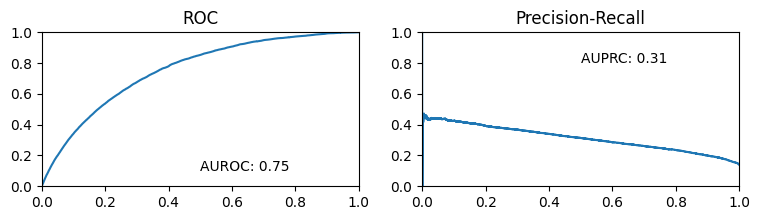

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

(0.0, 1.0)

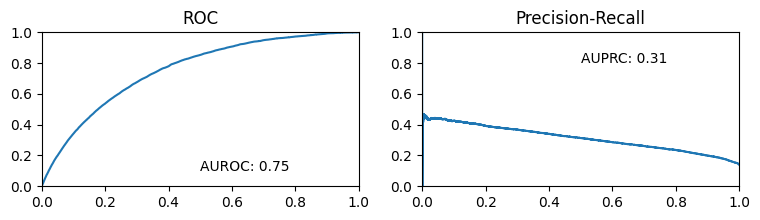

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))